### 1) What are the key factors driving the nightly rental price for units in the Austin area?


In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE

In [101]:
# Loading data

df = "/Users/anani/OneDrive - Old/Desktop/Machine Learning/Investing in Austin/airbnb_cleaned.csv"
airbnb_cleaned = pd.read_csv(df)

Explore Data (correlations, scatterplots) with only numeric data

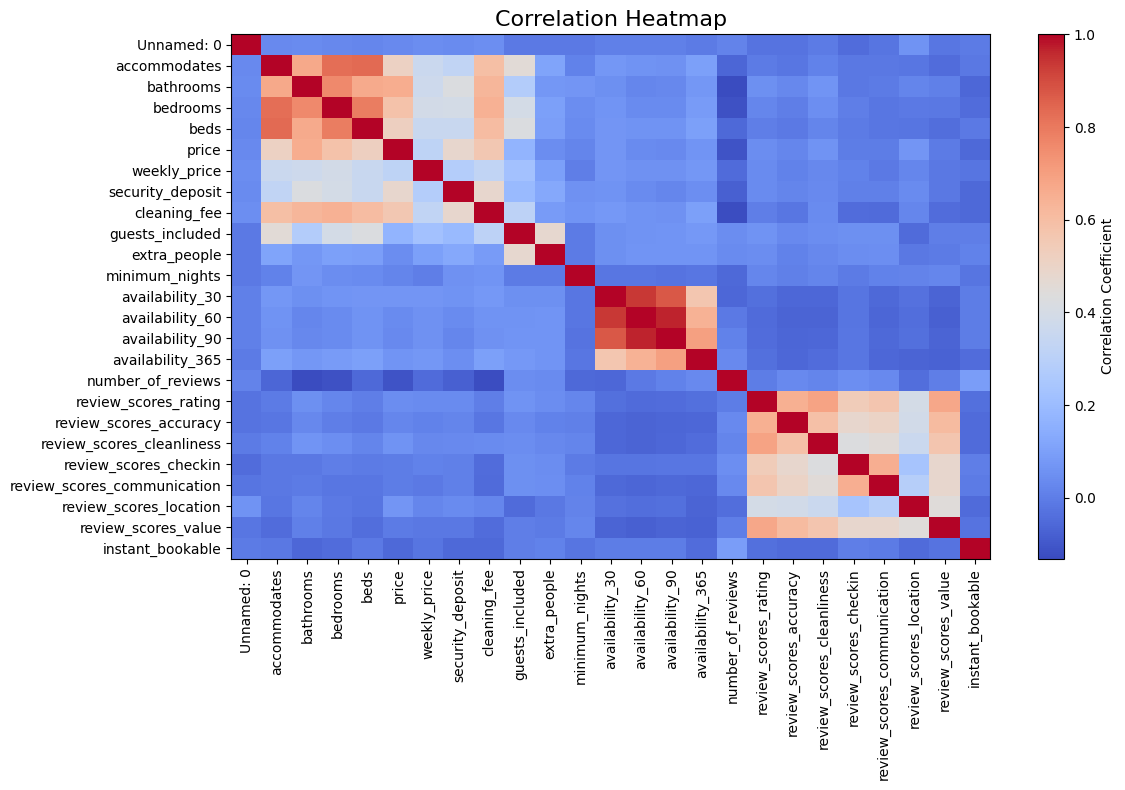

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Select numeric columns only
numeric_columns = airbnb_cleaned.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a correlation heatmap
plt.figure(figsize=(12, 8))
plt.title('Correlation Heatmap', fontsize=16)
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(heatmap, label='Correlation Coefficient')

# Add labels for clarity
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)

plt.tight_layout()
plt.show()


In [103]:
airbnb_cleaned.dtypes

Unnamed: 0                       int64
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
price                          float64
weekly_price                   float64
security_deposit               float64
cleaning_fee                   float64
guests_included                  int64
extra_people                   float64
minimum_nights                   int64
availability_30                  int64
availability_60                  int64
availability_90                  int64
availability_365                 int64
number_of_reviews              float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value      

Creating and running a full linear regression model with only numeric data

In [ ]:

dropped_columns = airbnb_cleaned[['room_type','cancellation_policy','bed_type']]
x = airbnb_cleaned.drop(columns=['price','room_type','cancellation_policy','bed_type'])
y = airbnb_cleaned['price']
reg_model = sm.OLS(y,x).fit()

In [105]:
print(reg_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.659
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                              317.9
Date:                Mon, 02 Dec 2024   Prob (F-statistic):                        0.00
Time:                        20:43:48   Log-Likelihood:                         -27670.
No. Observations:                3973   AIC:                                  5.539e+04
Df Residuals:                    3949   BIC:                                  5.554e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

Feature selection and deciding what variables to choose

In [106]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


In [107]:
selected_features  = stepwise_selection(x, y)
print('resulting features:')
print(selected_features)

Add  bathrooms with p-value 0.0000
Add  security_deposit with p-value 0.0000
Add  cleaning_fee with p-value 0.0000
Add  bedrooms with p-value 0.0000
Add  guests_included with p-value 0.0000
Add  review_scores_location with p-value 0.0001
Add  beds with p-value 0.0006
Add  minimum_nights with p-value 0.0032
Add  weekly_price with p-value 0.0074
resulting features:
['bathrooms', 'security_deposit', 'cleaning_fee', 'bedrooms', 'guests_included', 'review_scores_location', 'beds', 'minimum_nights', 'weekly_price']


Rerunning the model with selected features

In [108]:

x = airbnb_cleaned[['cleaning_fee', 'bathrooms', 'security_deposit',
                    'bedrooms', 'guests_included', 'review_scores_location',
                      'beds', 'minimum_nights', 'weekly_price']]
y = airbnb_cleaned['price']
# x = pd.get_dummies(x,columns=['room_type'], dtype= 'float')
reg_model_2 = sm.OLS(y,x).fit()

print(reg_model_2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.654
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                              832.7
Date:                Mon, 02 Dec 2024   Prob (F-statistic):                        0.00
Time:                        20:43:49   Log-Likelihood:                         -27698.
No. Observations:                3973   AIC:                                  5.541e+04
Df Residuals:                    3964   BIC:                                  5.547e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

Checking residuals and vif for homoskedacity (patterns in the error) to help determine if there is possiblu mulicolinearity

1) Variance Inflation Factor (VIF) measures the degree of multicollinearity in a regression model. Multicollinearity occurs when two or more predictor variables in a model are highly correlated, making it difficult to assess the individual contribution of each variable.
2) Homoskedasticity refers to a key assumption in linear regression and other statistical models, which states that the variance of the residuals (errors) is constant across all levels of the independent variables

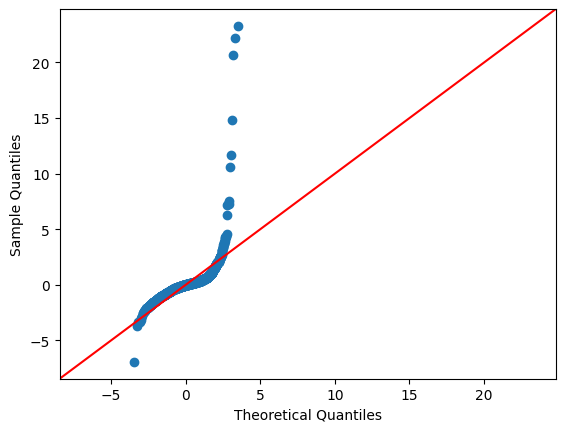

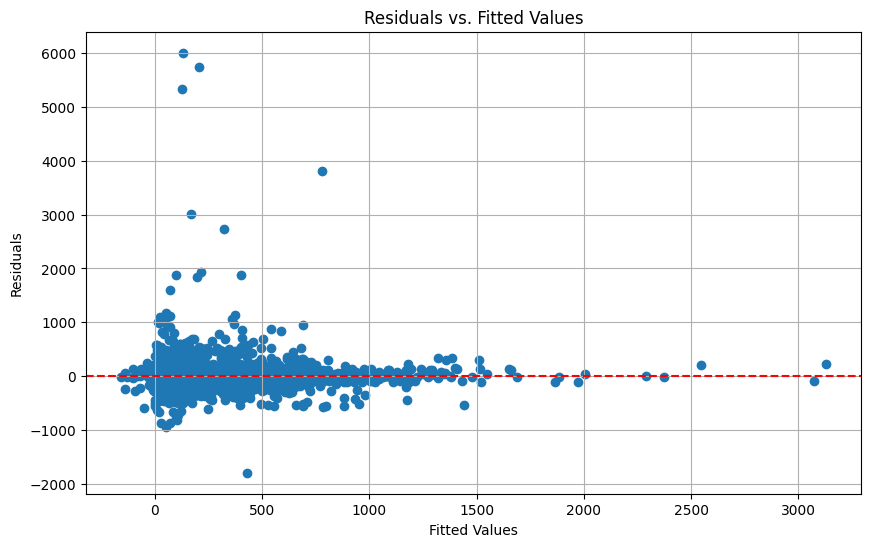

In [110]:
# Calculate residuals
residuals = reg_model_2.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals,fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(reg_model_2.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

VIF scores are not satisfactory there seems to be a high level of multicolinearity among certain features but, we can not remove 5 out of the 8 select features because we will lose too much information so we decided to use the ridge regression to shrink the coeffients thus mitigating their impact on the data

In [111]:
vifresstep = pd.DataFrame()
vifresstep["Variable"] = x.columns
vifresstep["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vifresstep)

                 Variable        VIF
0            cleaning_fee   6.641705
1               bathrooms  11.894555
2        security_deposit   2.938911
3                bedrooms  12.069958
4         guests_included   2.689963
5  review_scores_location   5.382344
6                    beds   7.839826
7          minimum_nights   1.522907
8            weekly_price   2.829759


Regularization
Ridge Regression penalizes large coefficients and reduces the impact of multicollinearity.

Ridge Regression Coefficients:
                 Variable  Coefficient
0            cleaning_fee    53.920818
1               bathrooms   138.596840
2        security_deposit    72.211802
3                bedrooms    34.747868
4         guests_included   -31.624284
5  review_scores_location    16.763073
6                    beds    23.173055
7          minimum_nights   -11.719483
8            weekly_price    12.090033

Variance Inflation Factor (VIF) after Ridge Regularization:
                 Variable       VIF
0            cleaning_fee  2.073775
1               bathrooms  2.677110
2        security_deposit  1.365692
3                bedrooms  3.796521
4         guests_included  1.256182
5  review_scores_location  1.008305
6                    beds  2.931454
7          minimum_nights  1.008470
8            weekly_price  1.231048


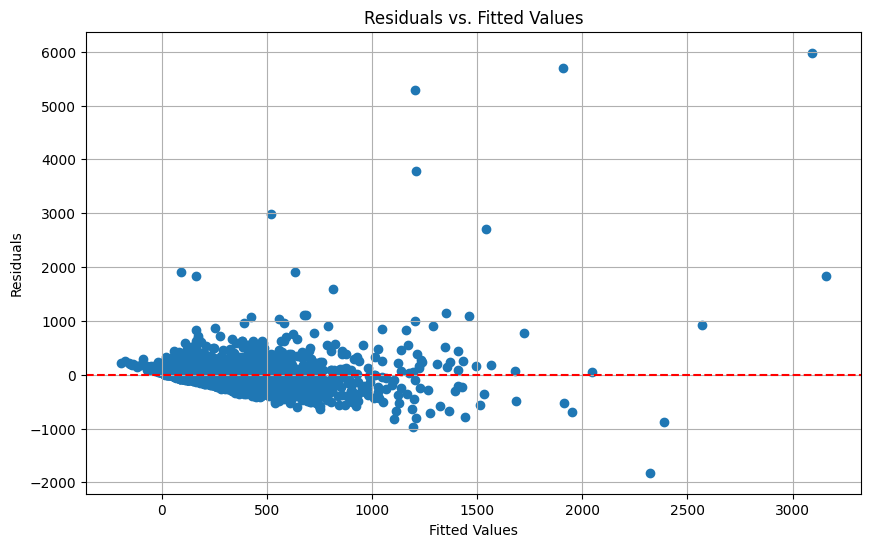

In [112]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define features (X) and target variable (y)
x = airbnb_cleaned[['cleaning_fee', 'bathrooms', 'security_deposit',
                    'bedrooms', 'guests_included', 'review_scores_location',
                    'beds', 'minimum_nights', 'weekly_price']]
y = airbnb_cleaned['price']

# Standardize features for Ridge Regression
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Adjust alpha as needed
ridge_model.fit(x_scaled, y)

# Display coefficients
ridge_coefficients = pd.DataFrame({
    'Variable': x.columns,
    'Coefficient': ridge_model.coef_
})
print("Ridge Regression Coefficients:")
print(ridge_coefficients)

# Calculate VIF for the standardized features
vif_data = pd.DataFrame()
vif_data['Variable'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x_scaled, i) for i in range(x_scaled.shape[1])]
print("\nVariance Inflation Factor (VIF) after Ridge Regularization:")
print(vif_data)

# Visualize Residuals (Residual analysis is only for linear regression)
# If you'd like, you can skip these visualizations, as they may not apply directly to Ridge.

# Residuals vs Fitted values
ridge_residuals = y - ridge_model.predict(x_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(ridge_model.predict(x_scaled), ridge_residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()


Log tranforming y

In [114]:
# log transformed regression
x = sm.add_constant(x)
logy = np.log(y)
logreg = sm.OLS(logy, x).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     614.2
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:43:49   Log-Likelihood:                -3312.3
No. Observations:                3973   AIC:                             6645.
Df Residuals:                    3963   BIC:                             6707.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

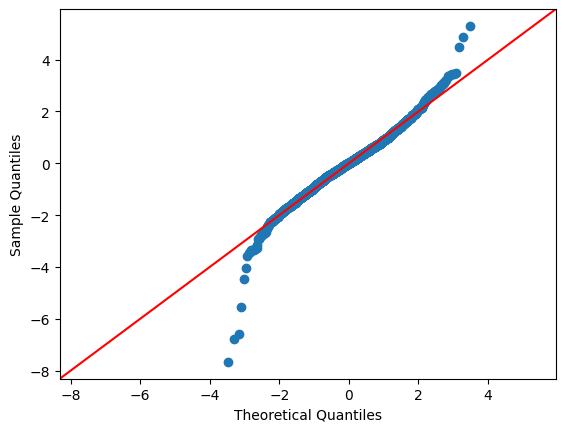

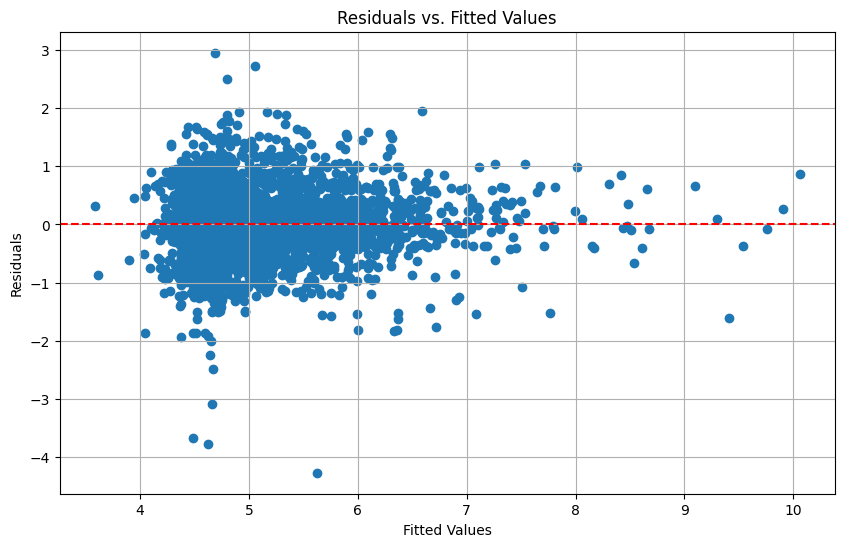

In [115]:
# Calculate residuals
logresiduals = logreg.resid

# Generate Q-Q Plot
logfig = sm.qqplot(logresiduals,fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg.fittedvalues, logresiduals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Considering both transformations, the log transform seems to be closest to constant variance. We will go ahead with log transformation, and now, introduce the categorical variables to produce the full model. 

Adding Categorical Variables with Dummies

In [ ]:
# adding categorical variables that were dropped during the intial regression process
x_beforedummies = airbnb_cleaned.add(dropped_columns, fill_value=0)
x_withdummies = pd.get_dummies(x_beforedummies,columns=['room_type','cancellation_policy','bed_type'], dtype= 'float')

In [ ]:
# dropping 'unnamed' column
x_withdummies = x_withdummies.drop(x_withdummies.columns[0], axis=1)


In [136]:
# log transformed regression
x_withdummies = sm.add_constant(x_withdummies)
logregdummies = sm.OLS(logy, x_withdummies).fit()

# Display regression summary
logregdummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     448.2
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:37:32   Log-Likelihood:                -1949.6
No. Observations:                3973   AIC:                             3967.
Df Residuals:                    3939   BIC:                             4181.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
const                                                                 1.7518      0.102     17.166      0.000       1.552       1.952
availability_30                                                       0.0086      0.002      5.002      0.000       0.005       0.012
availability_365                                                      0.0003   7.52e-05      4.082      0.000       0.000       0.000
availability_60                                                      -0.0018      0.002     -1.080      0.280      -0.005       0.001
availability_90                                                      -0.0015      0.001     -1.757      0.079      -0.003       0.000
bathrooms                                                             0.0669      0.014      4.851      0.000       0.040       0.094
bedrooms                                                              0.1072      0.011     10.187      0.000       0.087       0.128
beds                                                                  0.0092      0.006      1.500      0.134      -0.003       0.021
cleaning_fee                                                          0.0013      0.000      6.912      0.000       0.001       0.002
extra_people                                                          0.0005      0.000      1.924      0.054   -9.51e-06       0.001
guests_included                                                       0.0118      0.004      2.704      0.007       0.003       0.020
instant_bookable                                                     -0.0174      0.021     -0.845      0.398      -0.058       0.023
minimum_nights                                                       -0.0180      0.002     -8.082      0.000      -0.022      -0.014
number_of_reviews                                                    -0.0022      0.000     -9.522      0.000      -0.003      -0.002
price                                                                 0.0009   2.48e-05     37.524      0.000       0.001       0.001
review_scores_accuracy                                                0.0001      0.014      0.009      0.992      -0.027       0.028
review_scores_checkin                                                -0.0040      0.018     -0.223      0.823      -0.039       0.031
review_scores_cleanliness                                             0.0464      0.011      4.081      0.000       0.024       0.069
review_scores_communication                                           0.0111      0.018      0.611      0.541      -0.025       0.047
review_scores_location                                                0.0768      0.010      7.607      0.000       0.057       0.097
r

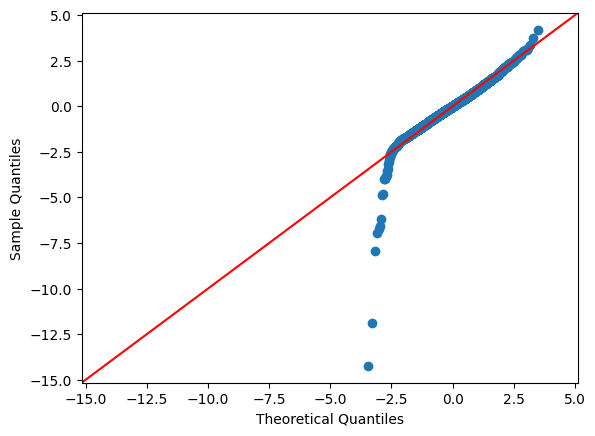

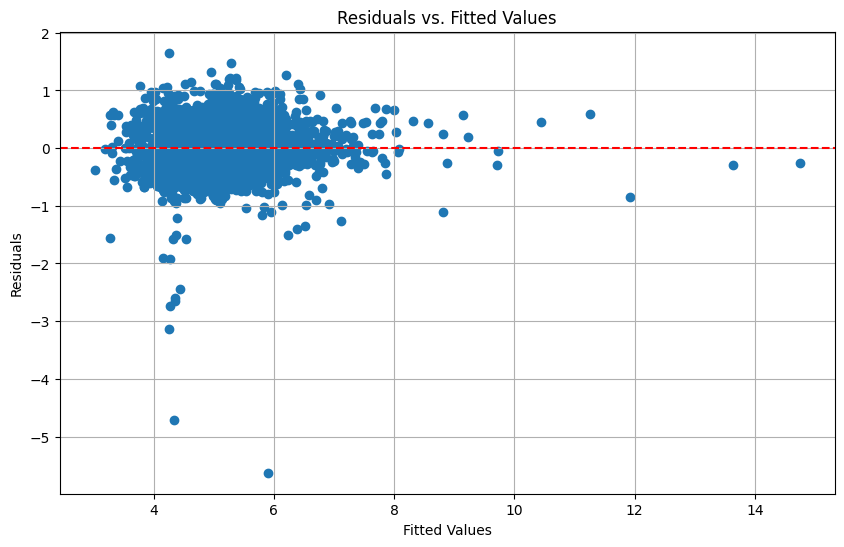

In [132]:
# Calculate residuals
logdummiesresiduals = logregdummies.resid

# Generate Q-Q Plot
logdummiesfig = sm.qqplot(logdummiesresiduals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logregdummies.fittedvalues, logdummiesresiduals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [133]:
sm.stats.acorr_ljungbox(logdummiesresiduals, lags=[10], return_df = True)

,lb_stat,lb_pvalue
10,33052.699488,0.0


After incorporating the dummies, we observed some of the dummies within the categorical variable to be significant. We still kept the dummies that had p values higher than 0.05 for interpretation ease. The residuals for the log transformed data after the dummies were incorporated show somewhat constant variance, without heteroskedasticity. Hence, this is our final model to answer the question. 